In [1]:
%pylab inline
%matplotlib inline

import os
os.chdir("/Users/Bya/git/predictEPL/MyFunctions/")
from dataIO import csv_dic_df

import time
import collections
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")
sys.path.append("/Users/Bya/git/predictEPL/WebScrapping/")

import paths
import espn_urls
import my_plot
import scrap_espn_gamecast
import emolex

import useful_methods
from useful_methods import FolderFiles
from useful_methods import csv_dic_df
from useful_methods import FilterDF
from useful_methods import PreprocessingTweet

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read Emolex
dic_emolex, dic_emolex_stemmed = emolex.EmolexDic()

# Read Soccer Emolex
dic_emolex_soccer, dic_emolex_stemmed_soccer = emolex.EmolexSoccerDic()

All Words: 14182
All Words: 14163


In [3]:
# choosing data
week = str(15)
GW = 'GW' + week
filenames = FolderFiles(GW + '/SingleGames', paths.READ_PATH_EXTRACTED_CSV, ends='.csv')
filenames

['Arsenal_vs_Sunderland.csv',
 'Chelsea_vs_Bournemouth.csv',
 'Everton_vs_Crystal.csv',
 'Newcastle_vs_Liverpool.csv',
 'Southampton_vs_Villa.csv',
 'Stoke_vs_City.csv',
 'Swansea_vs_Leicester.csv',
 'United_vs_WestHam.csv',
 'Watford_vs_Norwich.csv',
 'WestBromwich_vs_Tottenham.csv']

In [17]:
# Set Game
filename = filenames[3]

# Read DF
os.chdir(paths.READ_PATH_EXTRACTED_CSV + GW + '/SingleGames')
df = csv_dic_df(filename)

start_time = time.time()

# [Filter] DF
dfFilter = FilterDF(df)

# # [Filtered] All, Non-Retweet
# dfFilterEmolex = emolex.CreateEmolexDF(dfFilter, dic_emolex, dic_emolex_stemmed)
# dfFilterEmolexNonRetweet = emolex.CreateEmolexDF(dfFilter[dfFilter['status'] != 'retweet'], dic_emolex, dic_emolex_stemmed)

# # [Filtered] Home, Away
dfFilterEmolexSoccerHome = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'home'], dic_emolex_soccer, dic_emolex_stemmed_soccer)
dfFilterEmolexSoccerAway = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'away'], dic_emolex_soccer, dic_emolex_stemmed_soccer)

# # [Filtered, Non ReTweet] Home, Away
# dfFilterEmolexNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex, dic_emolex_stemmed)
# dfFilterEmolexNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex, dic_emolex_stemmed)

# [Filtered, Non ReTweet] Home, Away
dfFilterEmolexSoccerNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer, dic_emolex_stemmed_soccer)
dfFilterEmolexSoccerNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer, dic_emolex_stemmed_soccer)

print("[Done]: %.2f" % (time.time() - start_time))

[Done]: 19.63


In [5]:
# Scrap Gamecast
url = espn_urls.MatchUrl(GW, filename)
dfGameCast = scrap_espn_gamecast.CreateEspnLiveCommentDF(url)

# Create Goal, Attack, Foul dics
goals_dic, attacks_dic_home, attacks_dic_away, fouls_dic_home, fouls_dic_away = scrap_espn_gamecast.CreateGAFdics(dfGameCast)

[Match]: Newcastle United VS Liverpool
[Scrap Done]: 1.33 sec


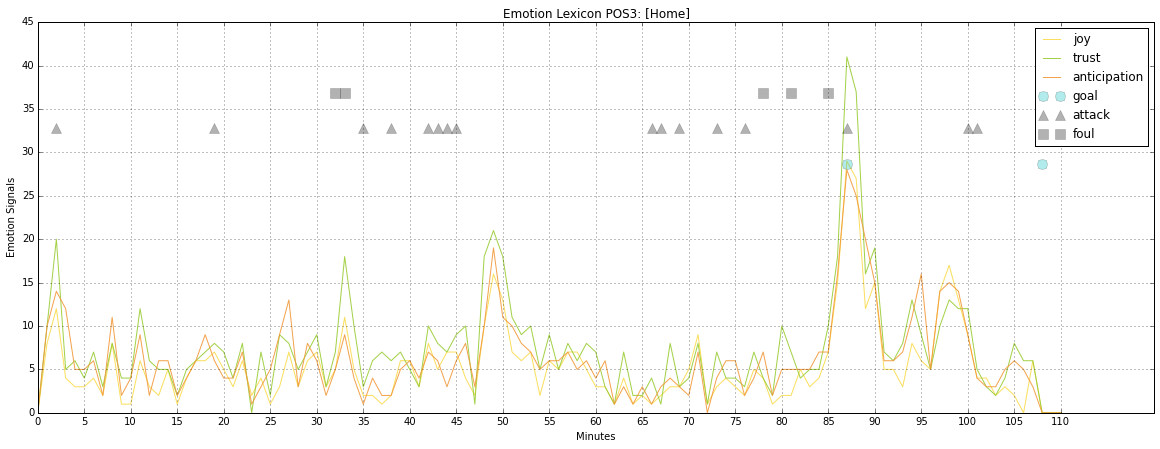

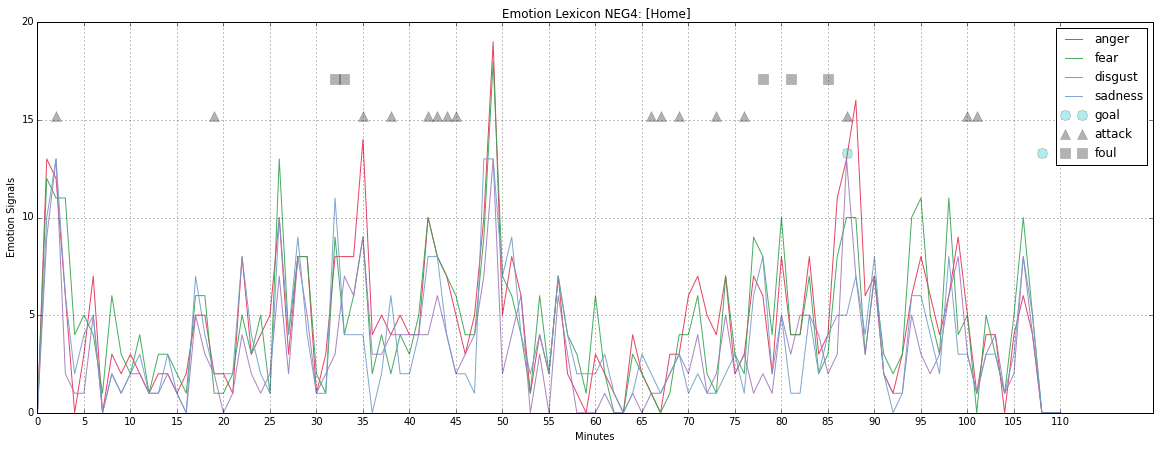

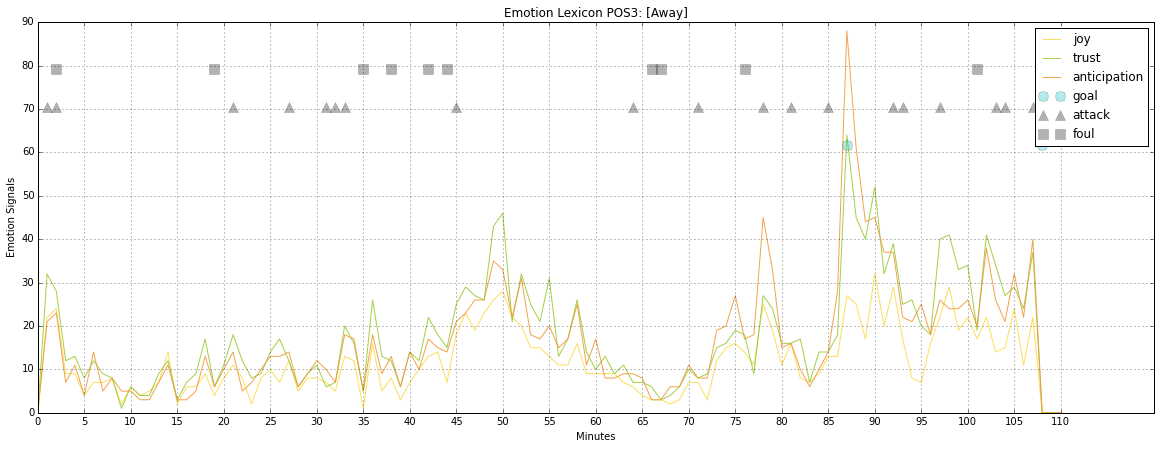

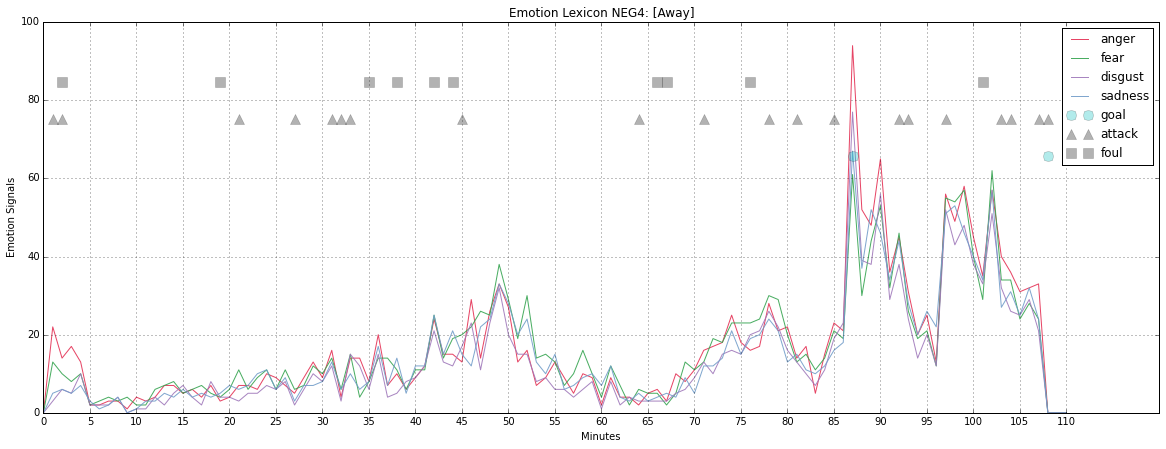

In [6]:
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtHome, goals_dic, attacks_dic_home, fouls_dic_home, title='Home')
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtAway, goals_dic, attacks_dic_away, fouls_dic_away, title='Away')

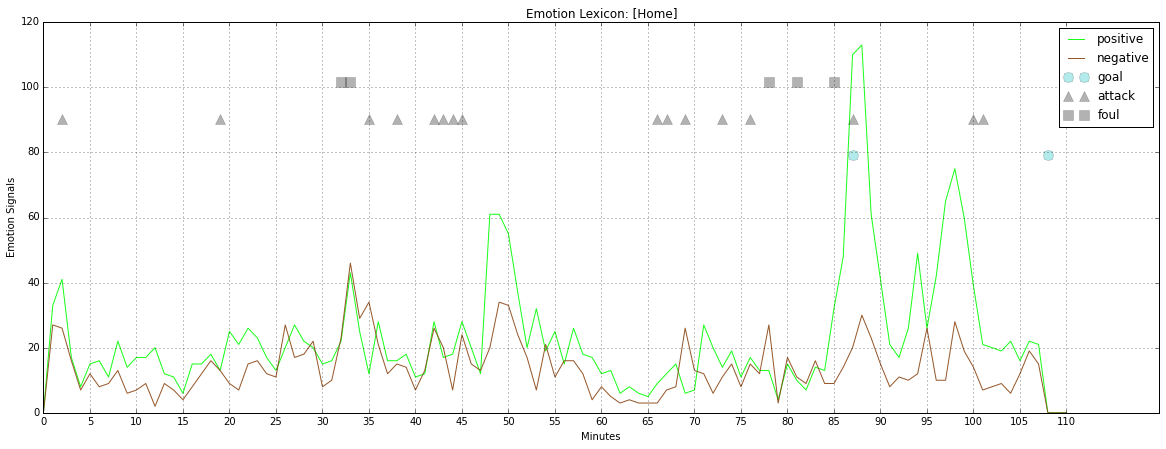

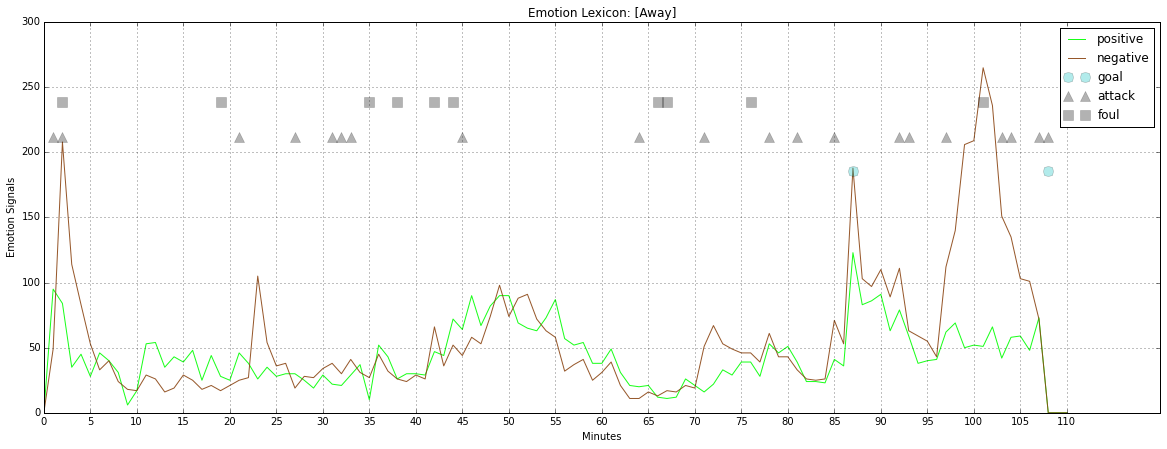

In [26]:
my_plot.EmolexCats(dfFilterEmolexSoccerHome, ['positive', 'negative'], goals_dic, attacks_dic_home, fouls_dic_home, 'Home')
my_plot.EmolexCats(dfFilterEmolexSoccerAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# Words Examination

In [20]:
# Set minute and side
start_minute = 85
end_minute = 110
side = 'away'

dfExamine = dfFilter.copy()
dfExamine['ith_minute'] = [int(ith_minte) for ith_minte in dfExamine['ith_minute']]

# extract tweets
tweets = list(dfExamine[
        (dfExamine['side'] == side) &
        (dfExamine['status'] != 'retweet') &
        (dfExamine['ith_minute'] >= start_minute) &
        (dfExamine['ith_minute'] <= end_minute)
    ]['text'])

print("[Tweets Number]: %s\n" % len(tweets))

# Create words lists. PreprocessingTweet
start_time = time.time()
all_words = []
all_words_stemmend = []
for tweet in tweets:
    words, words_stemmed = PreprocessingTweet(tweet)
    all_words += words
    all_words_stemmend += words_stemmed

print("[All Words]: %s" % (len(all_words)))
print("[Unique Words]: %s\n" % (len(set(all_words))))

print("[Most Common 10 Words]:")
useful_methods.ShowMostCommon(all_words)
print("\n")

print("[Emolex Words Count]:")
pprint(emolex.CountEmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words, all_words_stemmend))
print("\n")


print("[Passed Time]: %.2f sec" % (time.time() - start_time))

[Tweets Number]: 2739

[All Words]: 21754
[Unique Words]: 3291

[Most Common 10 Words]:
[('lfc', 2762),
 ('today', 321),
 ('goal', 264),
 ('liverpool', 252),
 ('http', 226),
 ('newcastle', 220),
 ('moreno', 176),
 ('game', 169),
 ('...', 165),
 ('offside', 153)]


[Emolex Words Count]:
{'anger': 945,
 'anticipation': 739,
 'disgust': 787,
 'fear': 825,
 'joy': 441,
 'negative': 1534,
 'positive': 1134,
 'sadness': 830,
 'surprise': 485,
 'trust': 752}


[Passed Time]: 1.72 sec


In [21]:
cat = 'positive'

emolex_words = emolex.EmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words, all_words_stemmend)

cat_words = emolex_words[cat]
useful_methods.ShowMostCommon(cat_words, 20)
len(cat_words)

[('good', 104),
 ('deserve', 57),
 ('title', 51),
 ('top', 33),
 ('hope', 29),
 ('absolute', 24),
 ('deserved', 23),
 ('talk', 19),
 ('winning', 18),
 ('forward', 18),
 ('luck', 16),
 ('love', 14),
 ('brilliant', 14),
 ('feeling', 13),
 ('actual', 12),
 ('fair', 12),
 ('completely', 11),
 ('united', 11),
 ('god', 11),
 ('job', 10)]


1134

In [24]:
dic_emolex['deserve']

{'anger': 1,
 'anticipation': 1,
 'disgust': 0,
 'fear': 0,
 'joy': 0,
 'negative': 0,
 'positive': 1,
 'sadness': 0,
 'surprise': 0,
 'trust': 1}

In [25]:
for tweet in tweets:
    if 'deserve' in tweet:
        print(tweet, '\n--------\n')

#LFC deserve fuck all from this game! Title challengers don't make me laugh 
--------

Well deserved Newcastle, we have been piss poor. #LFC #NEWLIV 
--------

Neither team deserves to win this game. Both been very poor. #LFC 
--------

Liverpool, you fucking deserve that. #LFC 
--------

We deserved that #Lfc very very poor 
--------

Got what we deserve on this performance. Nowt. Now we see if we have the bollocks #LFC 
--------

One of these games isn't it.... Got what we deserved so far! #LFC 
--------

What we deserve for the shite they served up today #LFC 
--------

Fully deserved... We've been wank #LFC 
--------

You can't say that's any less then we deserve....awful #LFC 
--------

Obvious that was coming...they defo deserve it tbf #LFC 
--------

#LFC deserved that unfortunately. 
--------

What we deserve absolutely useless today #LFC 
--------

Completely &amp; utterly deserved #LFC have been shocking!! 
--------

Exactly what #LFC deserve. Fucking dreadful all over the pa